Time:  0.005988359451293945


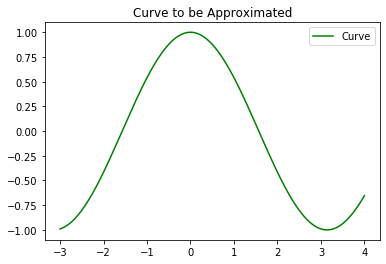

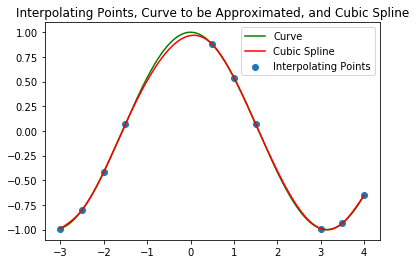

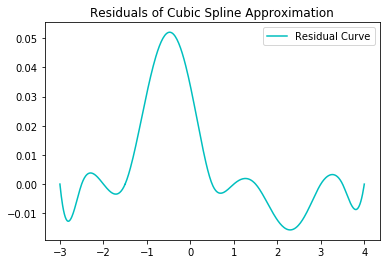

In [32]:
#Title: Cubic Spline Generator
#Team Name: NCSSM Unicorns
#Team Members: Dhruv Yalamanchi, Daniel Jin, Joseph Campbell, Shardool Deshpande, Akshat Kumar

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from qiskit.aqua.algorithms.classical import ExactLSsolver
import math
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer

#==================================================================================================
#we first give a lower and upper bound to define the region over which we will generate the points
lower_bound = -4
upper_bound = 4

#curve to be approximated
def curve(x):
    return np.cos(x)

#number of interpolating points we want (must be greater than 1)
num_points = 10
#==================================================================================================

#number of qubits needed to randomly generate numbers over the defined range
num = math.ceil(math.log(num_points,2))

#list of randomly generated x-coordinates
x_list = []


i = 0

while i < num_points:
    #define a quantum circuit with num qubits
    qpe = QuantumCircuit(num, num) 
    for j in range(num):
        qpe.h(j) 
    for j in range(num):
        qpe.measure(j,j)

    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    results = execute(qpe, backend=backend, shots=shots).result()
    answer = results.get_counts()
    res = list(answer.keys())[0] 
    output = int(res,2)+1
    step_size = (upper_bound - lower_bound)/(2 ** num)
    #ensures that all x-values are distinct
    if (lower_bound + (output)*step_size) in x_list:
        continue
    else:  
        #adds an x-coordinate to x_list corresponding to the outcome of measurement
        x_list.append(lower_bound + (output)*step_size)
        i+=1

#list of corresponding y-values
y_list = [curve(i) for i in x_list]


#list of interpolating points as ordered pairs
points = [(x_list[i],y_list[i]) for i in range(len(x_list))]

#start time
t = time.time()

#process of creating cubic spline
points.sort()

N = 4*(len(points)-1)

A = []
b = []

for i in range(1,len(points)):
    n = i-1
    x1,y1 = points[i-1][0],points[i-1][1]
    A.append((n*4)*[0] + [x1**3,x1**2,x1,1] + (N-4-n*4)*[0])
    b.append(y1)
    x2,y2 = points[i][0],points[i][1]
    A.append((n*4)*[0] + [x2**3,x2**2,x2,1] + (N-4-n*4)*[0])
    b.append(y2)

for i in range(1,len(points)-1):
    n = i-1
    x = points[i][0]
    A.append((n*4)*[0] + [3*x**2,2*x,1,0] + [-3*x**2,-2*x,-1,0] + (N-8-n*4)*[0])
    b.append(0)
    A.append((n*4)*[0] + [6*x,2,0,0] + [-6*x,-2,0,0] + (N-8-n*4)*[0])
    b.append(0)

xi = points[0][0]
A.append([6*xi,2,0,0] + (N-4)*[0])
b.append(0)

xf = points[-1][0]
A.append((N-4)*[0] + [6*xf,2,0,0])
b.append(0)

A = np.asarray(A, dtype=np.float32)
b = np.asarray(b, dtype=np.float32)

result_ref = ExactLSsolver(A, b).run()

vars = np.round(result_ref['solution'], 8)

x_list = [i[0] for i in points]
y_list = [i[1] for i in points]

x_inter = []
y_inter = []

for i in range(0,N,4):
    p = i//4
    numb = int(np.ceil(abs(x_list[p+1] - x_list[p])))
    x_points = np.linspace(x_list[p], x_list[p+1], num = numb*50).tolist()
    def f(x):
        return vars[i]*x**3 + vars[i+1]*x**2 + vars[i+2]*x + vars[i+3]
    y_points = [f(i) for i in x_points]
    x_inter += x_points
    y_inter += y_points

#end time
print("Time: ",time.time() - t)

#graph curve
y_curve = [curve(i) for i in x_inter]
plt.plot(x_inter,y_curve,'g', label="Curve")
plt.title('Curve to be Approximated')
plt.legend()
plt.show()

#graph actual curve with interpolating points and spline cuve
plt.scatter(x_list,y_list,label="Interpolating Points")
plt.plot(x_inter,y_curve,'g', label="Curve")
plt.plot(x_inter,y_inter,'r', label="Cubic Spline")
plt.title('Interpolating Points, Curve to be Approximated, and Cubic Spline')
plt.legend()
plt.show()

#graph error
error = [y_curve[i] - y_inter[i] for i in range(len(x_inter))]
plt.plot(x_inter,error,'c', label="Residual Curve")
plt.title('Residuals of Cubic Spline Approximation')
plt.legend()
plt.show()